# Handwritten digit recognition

## Import libraries

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

import matplotlib.pyplot as plt
import numpy as np

## Load dataset

In [2]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

## Visualize the data

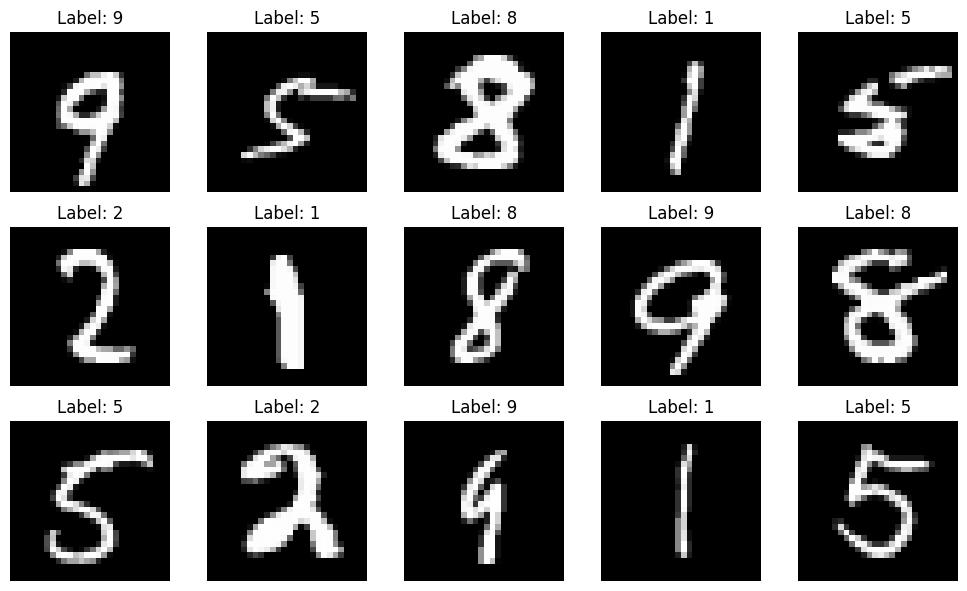

torch.Size([28, 28])


In [3]:
rows = 3
cols = 5
indices = np.random.choice(
    range(len(train_dataset)), size=rows*cols, replace=False
)
imgs = [train_dataset[i][0][0] for i in indices]
labels = [train_dataset[i][1] for i in indices]
fig, axs = plt.subplots(rows, cols, figsize=(10,6))
for idx, ax in enumerate(axs.flat):
    ax.imshow(imgs[idx], cmap='gray')
    ax.set(title=f"Label: {labels[idx]}")
    ax.axis('off')
plt.tight_layout()
plt.show()
print(imgs[0].shape)

## Split the data

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

## Define the model

In [5]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten x
        a = self.layers(x)
        return a

In [6]:
# Simple Early Stopping
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, test_loss):
        dif_loss = np.abs(test_loss - train_loss)
        print(f"Train_loss: {train_loss}, Test_loss: {test_loss}, Dif_loss: {dif_loss}")
        if dif_loss > self.min_delta:
            self.counter += 1
            print(f"Train loss is bad - tolerance counter is {self.counter}/{self.tolerance}")
            self.early_stop = self.counter >= self.tolerance


def avg(ls):
  if len(ls) == 0:
    return 0
  return np.sum(ls) / len(ls)



## Initialize the model and train

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP().to(device)

criterion = nn.CrossEntropyLoss()

# L2 = weight_decay (recommended values between range [0; 0.1])
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01, lr=0.001)

# Learning Rate Scheduling
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)

# Early Stopping
early_stopping = EarlyStopping(tolerance=8, min_delta=0.1)


# Losses
losses_train = []
losses_test = []

# Losses for calculate avg of all batches in every epoch
losses_train_batches = []
losses_test_batches = []

steps = len(train_dataset) // 64
epochs = 60
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss_train = criterion(outputs, labels)
        losses_train_batches.append(loss_train.item())

        loss_train.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f"Epoch: {epoch+1}/{epochs}, Step: {i+1}/{steps}, Train_Loss: {loss_train.item():.4f}")

    # Validation
    for i, (images_test, labels_test) in enumerate(test_loader):
        images_test, labels_test = images_test.to(device), labels_test.to(device)
        outputs_test = model(images_test)
        loss_test = criterion(outputs_test, labels_test)
        losses_test_batches.append(loss_test.item())

    # Calculate avg of batches losses and save in final losses lists
    loss_train_avg = avg(losses_train_batches)
    loss_test_avg = avg(losses_test_batches)
    losses_train.append(loss_train_avg)
    losses_test.append(loss_test_avg)

    # Reset losses batches lists
    losses_train_batches = []
    losses_test_batches = []


    # Early stopping
    early_stopping(loss_train_avg, loss_test_avg)
    if early_stopping.early_stop:
        print(f"Epoch stopping: {epoch+1}")
        break

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch+1}/{epochs} - Updating Learning Rate: {before_lr:.4f} -> {after_lr:.4f}")


print(f"Early stopping tolerance end with: {early_stopping.counter}/{early_stopping.tolerance}")


Epoch: 1/60, Step: 100/937, Train_Loss: 1.3064
Epoch: 1/60, Step: 200/937, Train_Loss: 1.5739
Epoch: 1/60, Step: 300/937, Train_Loss: 1.4986
Epoch: 1/60, Step: 400/937, Train_Loss: 1.4989
Epoch: 1/60, Step: 500/937, Train_Loss: 1.3900
Epoch: 1/60, Step: 600/937, Train_Loss: 1.6141
Epoch: 1/60, Step: 700/937, Train_Loss: 1.2451
Epoch: 1/60, Step: 800/937, Train_Loss: 1.3120
Epoch: 1/60, Step: 900/937, Train_Loss: 1.0698
Train_loss: 1.3603562556985598, Test_loss: 1.1269112293887291, Dif_loss: 0.23344502630983066
Epoch 1/60 - Updating Learning Rate: 0.0010 -> 0.0010
Epoch: 2/60, Step: 100/937, Train_Loss: 1.1657
Epoch: 2/60, Step: 200/937, Train_Loss: 0.9363
Epoch: 2/60, Step: 300/937, Train_Loss: 0.6392
Epoch: 2/60, Step: 400/937, Train_Loss: 0.7720
Epoch: 2/60, Step: 500/937, Train_Loss: 0.7339
Epoch: 2/60, Step: 600/937, Train_Loss: 0.5959
Epoch: 2/60, Step: 700/937, Train_Loss: 0.6593
Epoch: 2/60, Step: 800/937, Train_Loss: 0.9656
Epoch: 2/60, Step: 900/937, Train_Loss: 0.7505
Train_l

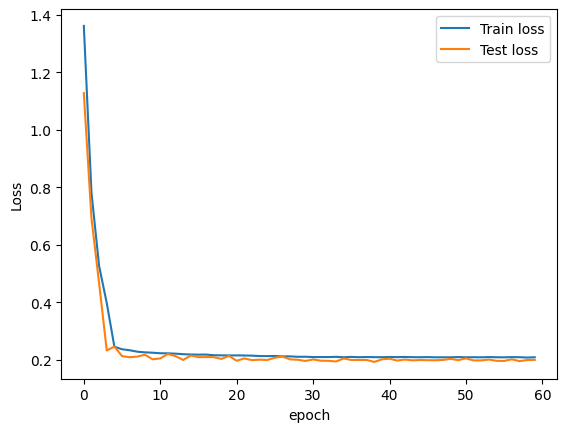

In [8]:
# Plot Losses

plt.plot(losses_train, label='Train loss')
plt.plot(losses_test, label='Test loss')
plt.ylabel('Loss')

plt.xlabel('epoch')
plt.legend(loc='best')

## Test the model

In [9]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print(f"Accuracy on test images: {100 * correct / total:.2f}%")

Accuracy on test images: 95.13%


## Visualize results

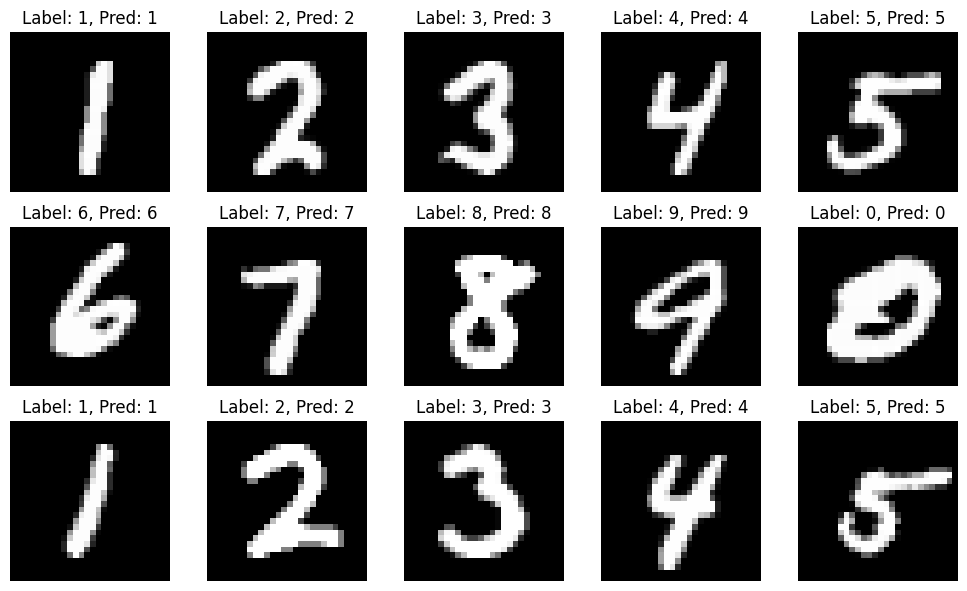

In [10]:
fig, axs = plt.subplots(rows, cols, figsize=(10,6))
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()
for idx, ax in enumerate(axs.flat):
    npimg = images[idx].squeeze().numpy()
    ax.imshow(npimg, cmap='gray')
    ax.set(title=f"Label: {labels[idx].item()}, Pred: {predicted[idx].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# TODOs:
1. [X] Add L2 regularization.
2. [X] Implement a learning rate scheduling strategy (e.g., Step).
3. [X] Increase the number of epochs, and implement early stoping.